<H1 style="text-align: center">Action Recognition - Vision Transformer</H1>

The aim of this project is to train a Vision Transformer (ViT) that can capture spatiotemporal information, and hence can classify videos.

This project will leaverage Vision Transformer (ViT) to recognize 25 actions in video data. ViT is a state-of-the-art
deep learning model with excellent performance on image classification tasks. Unlike the 3D CNN used in the original
project exercise, ViT does not directly process the raw video data. Instead, it first extracts visual features from the
video frames using a series of 2D convolutions and then feeds the features into a transformer-based architecture for
classification.

In [3]:
import os
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import clsHMDBModel as hmdbModel
from src import models
from clsLoadDataset import getDataLoader
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

### Download the data file from the repository

In [ ]:
import wget
import zipfile
target_dir = "data"
# Specify the URL and desired filename
url = 'https://zenodo.org/record/7718549/files/HMDB_simp.zip'
filename = 'HMDB_simp.zip'

# Download the file using wget
wget.download(url, filename)

# Extract the file to the target directory
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

In [11]:
print(f"File '{filename}' downloaded successfully.")

File 'HMDB_simp.zip' downloaded successfully.


Custom dataset implementation to loop through the HMDB_Simp data folder and to load the videos frames and labels

In [4]:
# get the dataset and data loader
ds = getDataLoader()

Print the number of videos to verify whether the entire dataset gets loaded for training

In [5]:
# Trying to find the number of videos
print('Number of Videos: ', len(ds))

Number of Videos:  1250


### Print the sample frames

Number of frames: 8
Action class: handstand


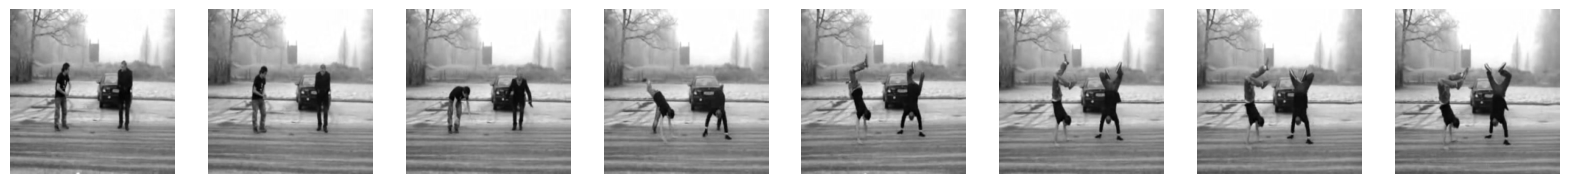

Action class: pick


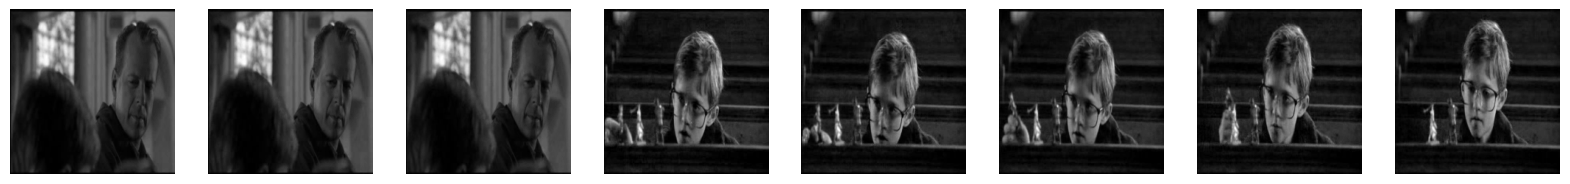

Action class: pullup


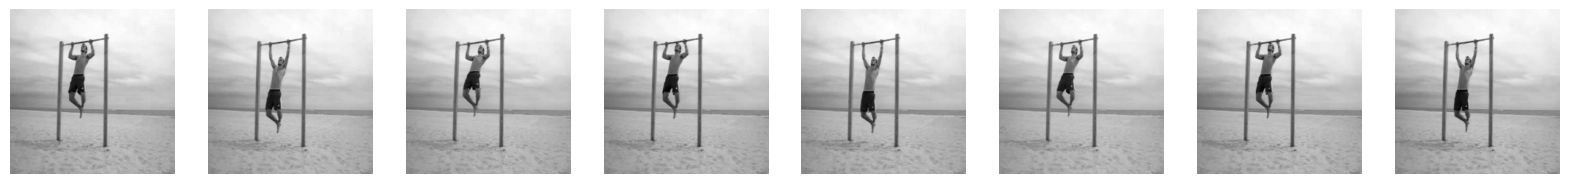

In [7]:
# Print the 8th Video and see the data from the Frames 
i = 10

import numpy as np
import matplotlib.pyplot as plt
# first video
video_01 = ds[551][0]
video_02 = ds[651][0]
video_03 = ds[751][0]
label_01 = ds[551][1]
label_02 = ds[651][1]
label_03 = ds[751][1]
# number of frames 
n = 8
# figure size
fig = plt.figure(figsize=(20, 15))
print('Number of frames: {}'.format(len(video_01)))
print('Action class: ' + ds.labels_ref[label_01])
for i in range(n):
    frame = video_01[i][1]
    fig.add_subplot(1, n, i + 1)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
plt.show()
print('Action class: ' + ds.labels_ref[label_02])
fig = plt.figure(figsize=(20, 15))
# index of equidistant frames
# nth_frames = np.linspace(0, len(video_09) - 1, n).astype(int)
for i in range(n):
    frame = video_02[i][1]
    fig.add_subplot(1, n, i + 1)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
plt.show()
print('Action class: ' + ds.labels_ref[label_03])
fig = plt.figure(figsize=(20, 15))
# index of equidistant frames
# nth_frames = np.linspace(0, len(video_09) - 1, n).astype(int)
for i in range(n):
    frame = video_03[i][1]
    fig.add_subplot(1, n, i + 1)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
plt.show()


### Split the dataset into train and test split

In [8]:
# Split the dataset into train and test sets
train_set, test_set = train_test_split(ds, test_size=0.2, random_state=42)

# Print out the sizes of each split
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 1000
Test set size: 250


### Set the model hyperparameters

In [9]:
# Initialize the model
model = models.init_model(name='vitb16')

# Set the learning rate and optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

# Set the batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)


Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TimesformerModel(
  (embeddings): TimesformerEmbeddings(
    (patch_embeddings): TimesformerPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
  )
  (encoder): TimesformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x TimesformerLayer(
        (drop_path): Identity()
        (attention): TimeSformerAttention(
          (attention): TimesformerSelfAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
          )
          (output): TimesformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): TimesformerIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.0, inpla

### Find the size of the frame to verify the parameters size

In [10]:

for batch_idx, data in enumerate(train_loader):
    # fetch the data
    frame, label = data[0], data[1]
    print("frame", frame.shape)
    print("label", label.shape)
    break

frame torch.Size([16, 8, 3, 224, 224])
label torch.Size([16])


### Train the model with the hyperparameters details

In [12]:
# Train the model
num_epoch = 1
#import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# create TensorBoard logger
writer = SummaryWriter('runs/hmdb_experiment_1')

for epoch in range(num_epoch):
    print(f"Epoch: {epoch+1}/{num_epoch}")
    avg_loss, label_s, pred_s, logits_s, loss_test = hmdbModel.train(model, train_loader, optimizer, device)
    
    accuracy = accuracy_score(torch.cat(label_s).cpu().numpy(), torch.cat(pred_s).cpu().numpy())    
    top1_accuracy = accuracy_score(torch.cat(label_s).cpu().numpy(), torch.cat(pred_s).cpu().numpy())
    logits_s = np.concatenate([logits.detach().cpu().numpy() for logits in logits_s])  # Convert list of tensors to numpy array
    top5_accuracy = hmdbModel.topk_accuracy(np.concatenate(label_s), logits_s, k=5)
    writer.add_scalar('training_loss', avg_loss, global_step = epoch)
    print("Accuracy:", accuracy)
    print("Top-1 Accuracy:", top1_accuracy)
    print("Top-5 Accuracy:", top5_accuracy)

Epoch: 1/1


Test:   0%|          | 0/63 [00:00<?, ?frames/s]

Train: Average loss: 1.6383



ValueError: too many values to unpack (expected 4)

### Plot the confusion matrix to find the average precision of the model

<Axes: >

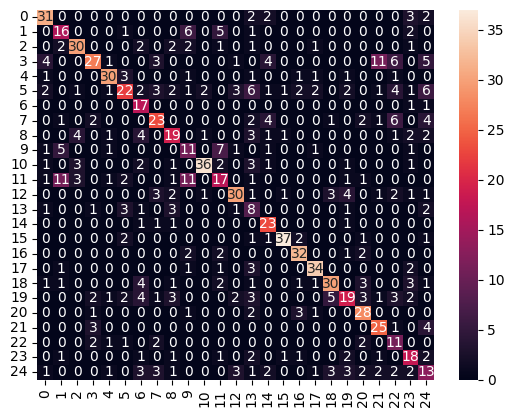

In [ ]:
# Calculate and plot confusion matrix
cf_max = confusion_matrix(torch.cat(pred_s).cpu().numpy(), torch.cat(label_s).cpu().numpy())
sns.heatmap(cf_max, annot=True, fmt='g')



### Save the model

In [ ]:
# Save the model trained on the first dataset
torch.save(model.state_dict(), "1E_16B_trained_model.pt")

### Classification report

In [ ]:
# Print the classification report to find the metrics
from sklearn.metrics import classification_report
cr = classification_report(torch.cat(pred_s).cpu().numpy(), torch.cat(label_s).cpu().numpy())
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        40
           1       0.42      0.52      0.46        31
           2       0.73      0.71      0.72        42
           3       0.71      0.44      0.54        62
           4       0.79      0.75      0.77        40
           5       0.61      0.34      0.44        65
           6       0.41      0.89      0.57        19
           7       0.59      0.50      0.54        46
           8       0.51      0.49      0.50        39
           9       0.31      0.38      0.34        29
          10       0.90      0.71      0.79        51
          11       0.45      0.34      0.39        50
          12       0.73      0.60      0.66        50
          13       0.19      0.38      0.25        21
          14       0.57      0.85      0.69        27
          15       0.90      0.82      0.86        45
          16       0.76      0.82      0.79        39
          17       0.81    

In [ ]:
model = torch.load('2E_8B_trained_model.pt')

### Test the model to verify the results

In [ ]:

avg_loss, label_test, pred_test, logits_test, loss_test = hmdbModel.test(model, test_loader, device)

accuracy = accuracy_score(torch.cat(label_test).cpu().numpy(), torch.cat(pred_test).cpu().numpy())   

logits_st = np.concatenate([logits.detach().cpu().numpy() for logits in logits_test])  # Convert list of tensors to numpy array
top5_accuracy = hmdbModel.topk_accuracy(np.concatenate(label_test), logits_st, k=5)
writer.add_scalar('training_loss', avg_loss, global_step = epoch)
print('Test Loss')
print('=========')
print("Accuracy:", accuracy)
print("Top-1 Accuracy:", top1_accuracy)
print("Top-5 Accuracy:", top5_accuracy)

NameError: name 'test_loader' is not defined

In [ ]:
# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%reload_ext tensorboard
%tensorboard --logdir runs/hmdb_experiment_1

### Tensorboard summary

In [ ]:
from torchsummary import summary
#summary(model, (3, 224, 224))
summary(model, (8, 3, 224, 224))

NameError: name 'model' is not defined